In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact_manual, widgets
import torch
import sys
import os
sys.path.append(os.path.expanduser('~/Desktop/Basset_E/'))
from sample.utils.load_model import load_model_E
import numpy as np
from Interpretation.utils import *
import json
import seaborn as sns

In [7]:
table  = pd.read_excel(PDBX+'data/tableS1A.xlsx',index_col=1)
a = table.iloc[0]
table = table[1:]
table.columns = a


# Data Loading

In [13]:
ls /home/emeunier/Dropbox/UBC/data/sasha_ATAC/

 Activation_BassetE_FilterS.csv   influence_motifs_sasha.csv
 CellOrderFinal.csv               one_hot_seqs.npy
 cell_type_array.npy              peak_names.npy
 cell_type_names.npy              perm_one_hot_seqs.npy
 cell_type_names.txt             'Sasha M - correlations.npy'
 cell_types_name.h5              'Sasha M - test_labels.npy'
 clusters_cell_types.json        'Sasha M - test_OCR_names.npy'
 deeplift_motifs.meme            'Sasha M - test_sequences.npy'
 deeplift_summary_sasha.csv      'Sasha M - train_labels.npy'
 filter_motifs_pwm99.meme        'Sasha M - train_sequences.npy'
 influence_bylineage_signed.csv   tableS1A.xlsx


In [14]:
run = '/home/emeunier/Dropbox/UBC/data/Runs_GA/Random_Population'
run2 = '/home/emeunier/Dropbox/UBC/data/Runs_GA/Run_28_11_F_10In_100It'

# Sasha motifs generated count
generated_smotifs = pd.read_csv('{}/global_count_motifs_sasha.csv'.format(run),index_col=0)
generated_smotifs_2 = pd.read_csv('{}/global_count_motifs_sasha.csv'.format(run2),index_col=0)

# Load Model ( please use the same as the one for motif generation)
t = torch.load(os.path.expanduser('~/Dropbox/UBC/Models/Basset_2019-11-04_19_23_35/model_loss_0.68.tar'))
m, _ = load_model_E()
m.load_state_dict(t['model_state_dict'])
m.eval();
activation = lambda x : 8*torch.sigmoid(x)+1
# Load Data
x = np.load(os.path.expanduser(os.path.expanduser('~/Dropbox/UBC/data/sasha_ATAC/perm_one_hot_seqs.npy'))) #load permuted sequences
x = x.astype(np.float32)

In [15]:
groups_publi = {'B':'B', 'myeloid':['DC','MF','Mo','GN'], 'innate.lym':'ILC', 'stem':'Stem', 'abT':'abT', 'gdT':'gdT'}
colors_groups = {'B':"rgb(232,177,21)", 'myeloid':"rgb(228,40,141)", 'innate.lym':"rgb(115,196,79)", 'stem':"rgb(201,201,201)", 'abT':"rgb(250,107,68)", 'gdT':"rgb(95,115,160)"}

# Analysis


## Generated Sequences Analysis

In [4]:
@interact_manual
def motif_frequence_sasha(ct = generated_smotifs.drop(columns=['Best overall TF match','Motif consensus Sequence']).columns) :
    go.Figure(go.Bar(y = generated_smotifs[ct], x =generated_smotifs.index)).show()

interactive(children=(Dropdown(description='ct', options=('Random',), value='Random'), Button(description='Run…

In [17]:
@interact_manual
def motifs_influence_sasha(motif=generated_smotifs.drop(columns=['Best overall TF match','Motif consensus Sequence']).max(axis=1).sort_values(ascending=False).index) :
    dfr = generated_smotifs.drop(columns= ['Best overall TF match','Motif consensus Sequence']).loc[motif]
    fig = go.Figure()
    fig.update_layout(title=" Presence of the motif in Generated Sequences : \n Filter : {} Motif : {} Length : {}".format(motif,generated_smotifs.loc[motif,'Best overall TF match'],len(generated_smotifs.loc[motif,'Motif consensus Sequence'])))
    fig.add_trace(go.Bar(x=dfr.index, y=dfr, name='generated'))
    fig.update_layout({
                           'yaxis': {'title': 'Presence', 'range': [0, 1]},
                           'barmode': 'relative'
                      })
    fig.show()
    h, b, _ = simulate(m, activation, x, motif_string=generated_smotifs.loc[motif,'Motif consensus Sequence'])
    b.update_layout({
                           'yaxis': {'title': 'Activation Motif', 'range': [1, 9]},
                           'barmode': 'relative'
                      })
    b.update_layout(title="Influence of the motif on the activation score")
    b.show()
    h.show()

interactive(children=(Dropdown(description='motif', options=('filter173', 'filter242', 'filter43', 'filter123'…

## Compare Motif Importance - Sasha Importance Score

In [39]:
sasha_importance = pd.read_csv(os.path.expanduser('~/Dropbox/UBC/data/influence_bylineage_signed.csv'),index_col=0)

In [40]:
fig = go.Figure(go.Bar(x=sasha_importance.index, y=sasha_importance['myeloid']))
fig.update_layout(yaxis_title="Importance im Sasha's model",
                      xaxis_title ="Filter")
fig.show()

In [41]:
print('Number of Motif found : {}/99'.format(len(generated_smotifs.index)))
print('Number of Motif found in less than 5% of the lineages: {}/{}'.format(len(generated_smotifs[generated_smotifs.drop(columns=['Best overall TF match','Motif consensus Sequence']).max(1) < 0.05 ].index),len(generated_smotifs.index)))

Number of Motif found : 99/99
Number of Motif found in less than 5% of the lineages: 6/99


In [42]:
sasha_importance = sasha_importance.loc[sorted(sasha_importance.index,key = lambda x : int(x.replace('filter','')))]
sasha_importance.rename(columns={'lym':'innate.lym'}, inplace=True)
#sasha_importance[sasha_importance < 0] = 0
#n_sasha_importance = (sasha_importance  - sasha_importance.min(0))/(sasha_importance.max(0)-sasha_importance.min(0))
comparaison = pd.merge(sasha_importance, generated_smotifs, left_index=True, right_index=True, suffixes=('_sasha','_generated'), how='left')
comparaison = comparaison.fillna(0)

### Global Importance ( Not Specific to cell types )

In [32]:
fig = go.Figure()
fig.add_trace(go.Bar(x=comparaison.index, y=comparaison[[c for c in comparaison.columns if 'sasha' in c]].max(1)))
fig.add_trace(go.Bar(x = comparaison.index, y=comparaison[[c for c in comparaison.columns if 'generated' in c]].max(1)))
fig.show()
go.Figure(go.Scatter(x = comparaison[[c for c in comparaison.columns if 'generated' in c]].max(1),
                     y = comparaison[[c for c in comparaison.columns if 'sasha' in c]].max(1),
                     mode='markers', text = comparaison.index))

### Importance by cell type

In [43]:
@interact_manual
def motifs_influence_sasha(ct=generated_smotifs.drop(columns=['Best overall TF match','Motif consensus Sequence']).columns) :
    fig = go.Figure(go.Scatter(y = comparaison['{}_generated'.format(ct)],
                         x = comparaison['{}_sasha'.format(ct)],
                         mode='markers+text',
                         text = comparaison['Best overall TF match'],
                         hovertext=comparaison.index,
                         textposition="bottom left"))
    fig.update_layout(title="Comparaison of feature importance for Lineage : {}".format(ct),
                      yaxis_title='Generated Motifs',
                      xaxis_title ="Sashas's motif importance")
    fig.show()


interactive(children=(Dropdown(description='ct', options=('abT', 'stem', 'gdT', 'B', 'innate.lym', 'myeloid'),…

### Heatmaps

In [19]:
ht_map = generated_smotifs[['B.','myeloid.','innate.lym.','abT.','stem.','gdT.']]
fig = go.Figure(go.Heatmap(z=ht_map,
                     x = ht_map.columns,
                     y=ht_map.index))
fig.update_layout(title="Proportion of the motif in the GA results")
fig.show()

In [30]:
fig = go.Figure(go.Heatmap(z=sasha_importance,
                     x = sasha_importance.columns,
                     y=sasha_importance.index))
fig.update_layout(title="Proportion of the motif in the GA results")
fig.show()

## Compare Motif Importance - BassetE Importance Score

In [5]:
be_importance = pd.read_csv(os.path.expanduser('~/Dropbox/UBC/data/Activation_BassetE_FilterS.csv'),index_col=0).drop(columns=['Best overall TF match','Motif consensus Sequence'])
#be_importance = (be_importance - 1)/8
be_importance['mean_importance'] =  be_importance.mean(axis=1)
comparaison_be = pd.merge(be_importance,
                       generated_smotifs,
                       left_index=True, right_index=True, suffixes=('_be','_generated'), how='left')
comparaison_be = comparaison_be.fillna(0)

In [74]:
comparaison_be

,B,myeloid,innate.lym,stem,abT,gdT,mean_importance,Random,Best overall TF match,Motif consensus Sequence
filter1,3.308,3.100,3.662,3.179,4.210,4.251,3.618333,0.0598,Atf3,TGAAGGATACGACGACATG
filter6,3.925,4.307,3.640,3.594,3.788,3.801,3.842500,0.0458,Ebf1,TTTCCCAATGGAATTTAAG
filter8,4.244,2.844,3.778,3.253,4.814,4.753,3.947667,0.0620,Zeb1,GAGGGCGCCCAGGTGAGAG
filter9,3.491,3.081,3.844,3.176,4.006,3.995,3.598833,0.0470,MOTIF NOT KNOWN,CGGCTGTACAGTGAACATC
filter10,3.386,2.743,4.238,3.952,4.381,4.479,3.863167,0.0470,Runx,TTTGTGGTTTGAATTGTAA
...,...,...,...,...,...,...,...,...,...,...
filter286,6.188,5.778,3.369,6.940,3.891,3.558,4.954000,0.0404,Sfpi1,CTATCTTACTTCCTCTTTT
filter288,3.324,3.145,4.448,3.193,4.091,3.914,3.685833,0.0494,Emoes,CAACTGGATTTCACACCTT
filter290,3.405,2.881,3.624,3.102,4.092,4.093,3.532833,0.0540,Mafg,TCATGCTGTGAGCATCATC
filter292,3.069,4.116,3.596,3.905,3.894,3.478,3.676333,0.0306,Fos,ATGAGTCATCACTTTACAC


In [63]:
comparaison_be

,B,myeloid,innate.lym,stem,abT,gdT,Random,Best overall TF match,Motif consensus Sequence
filter1,3.308,3.100,3.662,3.179,4.210,4.251,0.0598,Atf3,TGAAGGATACGACGACATG
filter6,3.925,4.307,3.640,3.594,3.788,3.801,0.0458,Ebf1,TTTCCCAATGGAATTTAAG
filter8,4.244,2.844,3.778,3.253,4.814,4.753,0.0620,Zeb1,GAGGGCGCCCAGGTGAGAG
filter9,3.491,3.081,3.844,3.176,4.006,3.995,0.0470,MOTIF NOT KNOWN,CGGCTGTACAGTGAACATC
filter10,3.386,2.743,4.238,3.952,4.381,4.479,0.0470,Runx,TTTGTGGTTTGAATTGTAA
...,...,...,...,...,...,...,...,...,...
filter286,6.188,5.778,3.369,6.940,3.891,3.558,0.0404,Sfpi1,CTATCTTACTTCCTCTTTT
filter288,3.324,3.145,4.448,3.193,4.091,3.914,0.0494,Emoes,CAACTGGATTTCACACCTT
filter290,3.405,2.881,3.624,3.102,4.092,4.093,0.0540,Mafg,TCATGCTGTGAGCATCATC
filter292,3.069,4.116,3.596,3.905,3.894,3.478,0.0306,Fos,ATGAGTCATCACTTTACAC


In [6]:
be_importance = pd.read_csv(os.path.expanduser('~/Dropbox/UBC/data/Activation_BassetE_FilterS.csv'),index_col=0).drop(columns=['Best overall TF match','Motif consensus Sequence'])
comparaison_be_2 = pd.merge(be_importance,
                       generated_smotifs_2,
                       left_index=True, right_index=True, suffixes=('_be','_generated'), how='left')
comparaison_be_2 = comparaison_be_2.fillna(0)

In [78]:
comparaison_be_2

,B_be,myeloid_be,innate.lym_be,stem_be,abT_be,gdT_be,mean_importance_be,abT_generated,stem_generated,gdT_generated,B_generated,innate.lym_generated,myeloid_generated,Best overall TF match,Motif consensus Sequence,mean_importance_generated
filter1,3.308,3.100,3.662,3.179,4.210,4.251,3.618333,0.013656,0.000667,0.005787,0.013164,0.024554,0.013628,Atf3,TGAAGGATACGACGACATG,0.011909
filter6,3.925,4.307,3.640,3.594,3.788,3.801,3.842500,0.002686,0.025550,0.006009,0.330210,0.002009,0.214477,Ebf1,TTTCCCAATGGAATTTAAG,0.096824
filter8,4.244,2.844,3.778,3.253,4.814,4.753,3.947667,0.062458,0.003333,0.018028,0.556002,0.188393,0.002904,Zeb1,GAGGGCGCCCAGGTGAGAG,0.138520
filter9,3.491,3.081,3.844,3.176,4.006,3.995,3.598833,0.012089,0.009331,0.057868,0.011156,0.021429,0.009383,MOTIF NOT KNOWN,CGGCTGTACAGTGAACATC,0.020209
filter10,3.386,2.743,4.238,3.952,4.381,4.479,3.863167,0.125140,0.409465,0.099711,0.005578,0.788393,0.027927,Runx,TTTGTGGTTTGAATTGTAA,0.242702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
filter286,6.188,5.778,3.369,6.940,3.891,3.558,4.954000,0.010298,0.197512,0.030492,0.689201,0.007366,0.991957,Sfpi1,CTATCTTACTTCCTCTTTT,0.321138
filter288,3.324,3.145,4.448,3.193,4.091,3.914,3.685833,0.121782,0.005110,0.192744,0.050201,0.128795,0.010054,Emoes,CAACTGGATTTCACACCTT,0.084781
filter290,3.405,2.881,3.624,3.102,4.092,4.093,3.532833,0.051936,0.130860,0.026708,0.040161,0.029687,0.024576,Mafg,TCATGCTGTGAGCATCATC,0.050655
filter292,3.069,4.116,3.596,3.905,3.894,3.478,3.676333,0.004030,0.344368,0.001558,0.005578,0.001786,0.027480,Fos,ATGAGTCATCACTTTACAC,0.064133


In [79]:
pd.merge(comparaison_be_2,table[['Reproducibility']], left_index=True, right_index=True)

,B_be,myeloid_be,innate.lym_be,stem_be,abT_be,gdT_be,mean_importance_be,abT_generated,stem_generated,gdT_generated,B_generated,innate.lym_generated,myeloid_generated,Best overall TF match,Motif consensus Sequence,mean_importance_generated,Reproducibility
filter1,3.308,3.100,3.662,3.179,4.210,4.251,3.618333,0.013656,0.000667,0.005787,0.013164,0.024554,0.013628,Atf3,TGAAGGATACGACGACATG,0.011909,10
filter6,3.925,4.307,3.640,3.594,3.788,3.801,3.842500,0.002686,0.025550,0.006009,0.330210,0.002009,0.214477,Ebf1,TTTCCCAATGGAATTTAAG,0.096824,10
filter8,4.244,2.844,3.778,3.253,4.814,4.753,3.947667,0.062458,0.003333,0.018028,0.556002,0.188393,0.002904,Zeb1,GAGGGCGCCCAGGTGAGAG,0.138520,10
filter9,3.491,3.081,3.844,3.176,4.006,3.995,3.598833,0.012089,0.009331,0.057868,0.011156,0.021429,0.009383,MOTIF NOT KNOWN,CGGCTGTACAGTGAACATC,0.020209,10
filter10,3.386,2.743,4.238,3.952,4.381,4.479,3.863167,0.125140,0.409465,0.099711,0.005578,0.788393,0.027927,Runx,TTTGTGGTTTGAATTGTAA,0.242702,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
filter286,6.188,5.778,3.369,6.940,3.891,3.558,4.954000,0.010298,0.197512,0.030492,0.689201,0.007366,0.991957,Sfpi1,CTATCTTACTTCCTCTTTT,0.321138,10
filter288,3.324,3.145,4.448,3.193,4.091,3.914,3.685833,0.121782,0.005110,0.192744,0.050201,0.128795,0.010054,Emoes,CAACTGGATTTCACACCTT,0.084781,10
filter290,3.405,2.881,3.624,3.102,4.092,4.093,3.532833,0.051936,0.130860,0.026708,0.040161,0.029687,0.024576,Mafg,TCATGCTGTGAGCATCATC,0.050655,9
filter292,3.069,4.116,3.596,3.905,3.894,3.478,3.676333,0.004030,0.344368,0.001558,0.005578,0.001786,0.027480,Fos,ATGAGTCATCACTTTACAC,0.064133,10


In [52]:
fig = go.Figure(go.Scatter(y = comparaison_be['Random'],
                     x = comparaison_be['memoryview'],
                     mode='markers+text',
                     text = comparaison_be['Best overall TF match'],
                     hovertext=comparaison_be.index,
                     textposition="bottom left"))
fig.update_layout(title="Comparaison of feature importance for Lineage : {}".format('B'),
                  yaxis_title='Generated Motifs',
                  xaxis_title ="BassetE's motif importance")
fig.show()

In [49]:
@interact_manual
def motifs_influence_sasha(ct=generated_smotifs_2.drop(columns=['Best overall TF match','Motif consensus Sequence']).columns) :
    fig = go.Figure(go.Scatter(y = comparaison_be_2['{}_generated'.format(ct)],
                         x = comparaison_be_2['{}_be'.format(ct)],
                         mode='markers+text',
                         text = comparaison_be_2['Best overall TF match'],
                         hovertext=comparaison_be_2.index,
                         textposition="bottom left"))
    fig.update_layout(title="Comparaison of feature importance for Lineage : {}".format(ct),
                      yaxis_title='Generated Motifs',
                      xaxis_title ="BassetE's motif importance")
    fig.show()


interactive(children=(Dropdown(description='ct', options=('abT', 'stem', 'gdT', 'B', 'innate.lym', 'myeloid', …

# Graph Poster

In [10]:
be_importance = pd.read_csv(os.path.expanduser('~/Dropbox/UBC/data/Activation_BassetE_FilterS.csv'),index_col=0).drop(columns=['Best overall TF match','Motif consensus Sequence'])
comparaison_be_2 = pd.merge(be_importance,
                       generated_smotifs_2,
                       left_index=True, right_index=True, suffixes=('_be','_generated'), how='left')
comparaison_be_2 = comparaison_be_2.fillna(0)
aga = pd.merge(comparaison_be_2,table[['Reproducibility']], left_index=True, right_index=True)

In [16]:
aga['Reproducibility'].nunique()

3

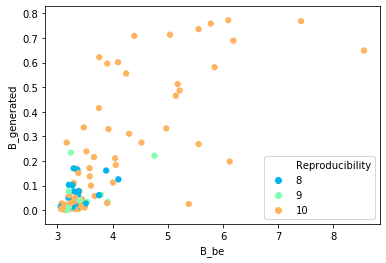

In [19]:
sns.scatterplot(x='B_be', y='B_generated', hue='Reproducibility', palette=sns.color_palette('rainbow',3), s=40, linewidth=0,legend='full',data=aga)
plt.xlabel("Average DeepLIFT Importance Score", fontsize=15)
plt.ylabel("Log of Influence of Best Match", fontsize=15)